In [1]:
# MODEL 2: TRANSFER LEARNING WITH EFFICIENTNET
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
# Load data
df = pd.read_csv("urgent_care_images_master_final.csv")

In [2]:
# Create train/val/test splits and define variables
from sklearn.model_selection import train_test_split

# Stratified split
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

# Define missing constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
n_classes = len(df['label'].unique())
all_classes = sorted(df['label'].unique())

print(f"Number of classes: {n_classes}")
print("Classes:", all_classes)

# Calculate clean class weights (avoiding tensor issues)
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

# Create clean class weight dictionary with proper Python floats
class_weight_dict = {}
for i, class_name in enumerate(all_classes):
    weight_idx = np.where(np.unique(train_df['label']) == class_name)[0][0]
    class_weight_dict[i] = float(class_weights_array[weight_idx])

print("Clean class weights:", class_weight_dict)

Train: (6084, 2)
Val: (1304, 2)
Test: (1304, 2)
Number of classes: 8
Classes: ['burn_1and2', 'burn_3rd', 'wound_abrasions', 'wound_bruises', 'wound_diabetic_wounds', 'wound_laceration', 'wound_pressure_wounds', 'wound_venous_wounds']
Clean class weights: {0: 0.22282449457954878, 1: 0.8431263858093127, 2: 4.370689655172414, 3: 2.9823529411764707, 4: 2.3472222222222223, 5: 3.0542168674698793, 6: 1.8064133016627077, 7: 2.197976878612717}


In [3]:
# Define missing variables from your first model
# These should come from your previous work or be defined here

# Image size and batch size
IMG_SIZE = (224, 224)  # Standard for EfficientNet
BATCH_SIZE = 32

# Get the data splits (assuming you have these from previous cells)
# If you don't have these, you need to run the train_test_split code first
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape) 
print("Test shape:", test_df.shape)

# Number of classes
n_classes = len(df['label'].unique())
print(f"Number of classes: {n_classes}")

# Also get all_classes and class_weight_dict from previous model
all_classes = sorted(df['label'].unique())
print("Classes:", all_classes)

Train shape: (6084, 2)
Val shape: (1304, 2)
Test shape: (1304, 2)
Number of classes: 8
Classes: ['burn_1and2', 'burn_3rd', 'wound_abrasions', 'wound_bruises', 'wound_diabetic_wounds', 'wound_laceration', 'wound_pressure_wounds', 'wound_venous_wounds']


In [4]:

# Create standard data generators for transfer learning
#  transfer learning,  conservative augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.85, 1.15],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen2 = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',  # Correct column name
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True,
    classes=all_classes  # Ensure consistent class ordering
)

val_gen2 = val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',  # Correct column name
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False,
    classes=all_classes
)

test_gen2 = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',  # Correct column name
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False,
    classes=all_classes
)

print("Data generators for Model 2 created!")

Found 6084 validated image filenames belonging to 8 classes.
Found 1304 validated image filenames belonging to 8 classes.
Found 1304 validated image filenames belonging to 8 classes.
Data generators for Model 2 created!


In [5]:
# Build EfficientNet transfer learning model
def create_efficientnet_model(num_classes):
    """EfficientNet-based transfer learning model"""
    
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Add custom top layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Create Model 2
model2, base_model = create_efficientnet_model(n_classes)

# Compile with higher learning rate for initial training
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("EfficientNet model structure:")
model2.summary()

EfficientNet model structure:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization_1 (Ba

In [6]:
# Convert class weights to regular Python floats to avoid serialization issues
print("Original class_weight_dict:")
print(class_weight_dict)

# Clean the class weight dictionary
clean_class_weight_dict = {}
for key, value in class_weight_dict.items():
    if hasattr(value, 'numpy'):  # Check if it's a tensor
        clean_class_weight_dict[key] = float(value.numpy())
    elif isinstance(value, np.ndarray):  # Check if it's a numpy array
        clean_class_weight_dict[key] = float(value)
    else:
        clean_class_weight_dict[key] = float(value)

print("\nCleaned class_weight_dict:")
print(clean_class_weight_dict)

# Replace the original with the cleaned version
class_weight_dict = clean_class_weight_dict

Original class_weight_dict:
{0: 0.22282449457954878, 1: 0.8431263858093127, 2: 4.370689655172414, 3: 2.9823529411764707, 4: 2.3472222222222223, 5: 3.0542168674698793, 6: 1.8064133016627077, 7: 2.197976878612717}

Cleaned class_weight_dict:
{0: 0.22282449457954878, 1: 0.8431263858093127, 2: 4.370689655172414, 3: 2.9823529411764707, 4: 2.3472222222222223, 5: 3.0542168674698793, 6: 1.8064133016627077, 7: 2.197976878612717}


In [7]:

# Emergency training without ModelCheckpoint (to isolate the issue)
print("Phase 1: Training with frozen EfficientNet base...")

callbacks_phase1 = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.3, patience=3, min_lr=1e-7, monitor='val_loss')
    # ModelCheckpoint removed temporarily to avoid serialization issues
]

# Train phase 1
EPOCHS_PHASE1 = 15
history2_phase1 = model2.fit(
    train_gen2,
    validation_data=val_gen2,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1,
    verbose=1
)

print("Phase 1 training completed!")

Phase 1: Training with frozen EfficientNet base...
Epoch 1/15
191/191 [==============================] - 34s 166ms/step - loss: 2.0989 - accuracy: 0.3585 - val_loss: 1.4847 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 2/15
191/191 [==============================] - 31s 161ms/step - loss: 1.6935 - accuracy: 0.5122 - val_loss: 1.4821 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 3/15
191/191 [==============================] - 31s 162ms/step - loss: 1.6496 - accuracy: 0.5253 - val_loss: 1.4816 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 4/15
191/191 [==============================] - 33s 170ms/step - loss: 1.6059 - accuracy: 0.5394 - val_loss: 1.4907 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 5/15
191/191 [==============================] - 32s 166ms/step - loss: 1.5715 - accuracy: 0.5452 - val_loss: 1.4782 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 6/15
191/191 [==============================] - 32s 165ms/step - loss: 1.5596 - accuracy: 0.5449 - val_loss: 1.5023 - val_accuracy: 0.5613 - lr: 0.0010
P

In [8]:
# Phase 2 - Fine-tune with unfrozen layers
print("Phase 2: Fine-tuning with unfrozen layers...")

# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) // 2

# Freeze all the layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with much lower learning rate
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable layers: {sum([layer.trainable for layer in model2.layers])}")


Phase 2: Fine-tuning with unfrozen layers...
Trainable layers: 11


In [10]:
# Train Phase 2 (Fine-tuning) - without ModelCheckpoint to avoid serialization issues
callbacks_phase2 = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-8, monitor='val_loss')
    # ModelCheckpoint removed to avoid serialization issues
]

EPOCHS_PHASE2 = 20
history2_phase2 = model2.fit(
    train_gen2,
    validation_data=val_gen2,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    class_weight=class_weight_dict,
    verbose=1
)

print("Phase 2 fine-tuning completed!")

Epoch 1/20
191/191 [==============================] - 32s 165ms/step - loss: 2.3215 - accuracy: 0.4502 - val_loss: 1.7609 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 2/20
191/191 [==============================] - 32s 167ms/step - loss: 2.1838 - accuracy: 0.4324 - val_loss: 1.6559 - val_accuracy: 0.5491 - lr: 1.0000e-04
Epoch 3/20
191/191 [==============================] - 32s 165ms/step - loss: 2.1134 - accuracy: 0.4147 - val_loss: 1.2290 - val_accuracy: 0.5759 - lr: 1.0000e-04
Epoch 4/20
191/191 [==============================] - 32s 170ms/step - loss: 2.0014 - accuracy: 0.4080 - val_loss: 1.9844 - val_accuracy: 0.1426 - lr: 1.0000e-04
Epoch 5/20
191/191 [==============================] - 32s 169ms/step - loss: 1.9767 - accuracy: 0.4098 - val_loss: 2.0238 - val_accuracy: 0.2071 - lr: 1.0000e-04
Epoch 6/20
191/191 [==============================] - 32s 166ms/step - loss: 1.9370 - accuracy: 0.4061 - val_loss: 2.3003 - val_accuracy: 0.1817 - lr: 1.0000e-04
Epoch 7/20
191/191 [========

In [11]:
# Save the final model manually after training
try:
    model2.save("efficientnet_transfer_model", save_format='tf')
    print("Model saved in SavedModel format!")
except:
    model2.save_weights("efficientnet_model_weights.h5")
    print("Model weights saved!")

INFO:tensorflow:Assets written to: efficientnet_transfer_model\assets


INFO:tensorflow:Assets written to: efficientnet_transfer_model\assets


Model weights saved!


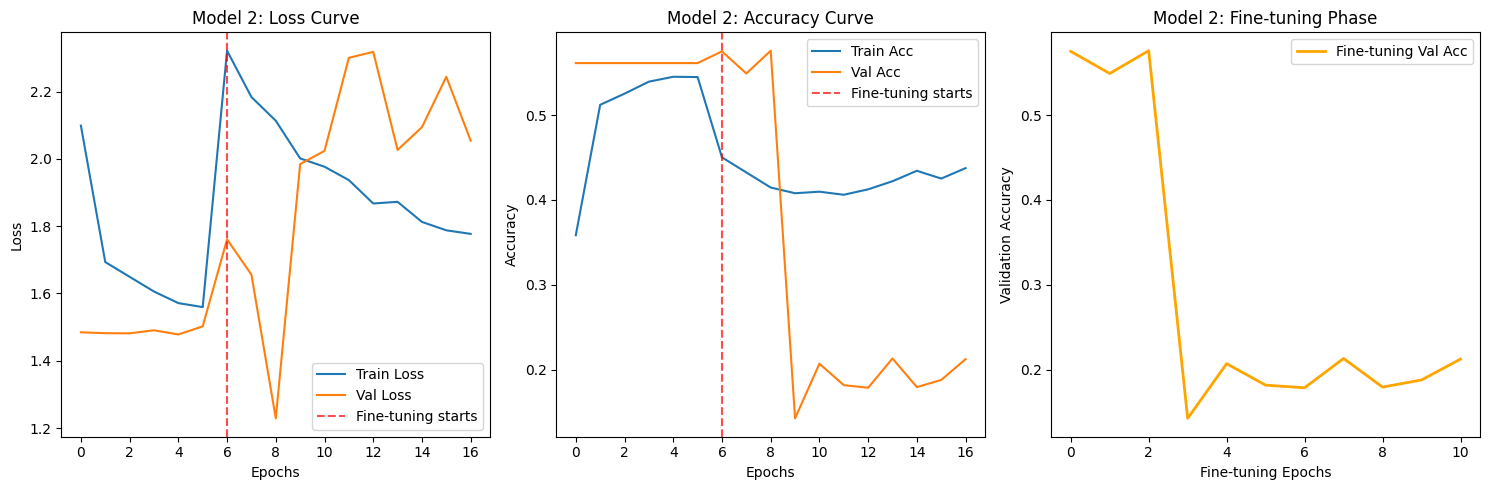

In [12]:
#  Plot training history for Model 2
plt.figure(figsize=(15, 5))

# Combine histories from both phases
total_epochs_phase1 = len(history2_phase1.history['loss'])
total_epochs_phase2 = len(history2_phase2.history['loss'])

combined_loss = history2_phase1.history['loss'] + history2_phase2.history['loss']
combined_val_loss = history2_phase1.history['val_loss'] + history2_phase2.history['val_loss']
combined_acc = history2_phase1.history['accuracy'] + history2_phase2.history['accuracy']
combined_val_acc = history2_phase1.history['val_accuracy'] + history2_phase2.history['val_accuracy']

epochs_range = range(total_epochs_phase1 + total_epochs_phase2)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, combined_loss, label='Train Loss')
plt.plot(epochs_range, combined_val_loss, label='Val Loss')
plt.axvline(x=total_epochs_phase1, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.title('Model 2: Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, combined_acc, label='Train Acc')
plt.plot(epochs_range, combined_val_acc, label='Val Acc')
plt.axvline(x=total_epochs_phase1, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.title('Model 2: Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(total_epochs_phase2), history2_phase2.history['val_accuracy'], 
         label='Fine-tuning Val Acc', color='orange', linewidth=2)
plt.title('Model 2: Fine-tuning Phase')
plt.xlabel('Fine-tuning Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Evaluate Model 2 on test set
print("Evaluating Model 2 on test set...")
test_loss, test_acc = model2.evaluate(test_gen2, verbose=1)

print("="*50)
print("MODEL 2 (EfficientNet) RESULTS")
print("="*50)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"Improvement over baseline (~74.1%): {(test_acc-0.741)*100:+.1f}%")

# Training progression
print(f"\nTraining Progression:")
print(f"Phase 1 best validation accuracy: {max(history2_phase1.history['val_accuracy']):.4f}")
if 'history2_phase2' in locals():
    print(f"Phase 2 best validation accuracy: {max(history2_phase2.history['val_accuracy']):.4f}")
    print(f"Final test accuracy: {test_acc:.4f}")
else:
    print("Phase 2 not completed yet")
    print(f"Current test accuracy: {test_acc:.4f}")

Evaluating Model 2 on test set...
41/41 [==============================] - 2s 40ms/step - loss: 1.2997 - accuracy: 0.5567
MODEL 2 (EfficientNet) RESULTS
Test Accuracy: 0.5567 (55.7%)
Test Loss: 1.2997
Improvement over baseline (~74.1%): -18.4%

Training Progression:
Phase 1 best validation accuracy: 0.5613
Phase 2 best validation accuracy: 0.5759
Final test accuracy: 0.5567


In [16]:
# Save the model
try:
    model2.save("efficientnet_transfer_model", save_format='tf')
    print("Model saved in SavedModel format!")
except Exception as e:
    print(f"SavedModel failed: {e}")
    try:
        model2.save_weights("efficientnet_model_weights.h5")
        print("Model weights saved as backup!")
    except Exception as e2:
        print(f"Weight saving also failed: {e2}")

INFO:tensorflow:Assets written to: efficientnet_transfer_model\assets


INFO:tensorflow:Assets written to: efficientnet_transfer_model\assets


SavedModel failed: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Model weights saved as backup!
